In [97]:
import os.path, logging
import numpy as np
import pandas as pd
from keras.layers import Input, Embedding, concatenate, dot
from keras.layers.core import Flatten, Dense, Dropout, Lambda
from keras.layers.normalization import BatchNormalization
from keras.models import Model
from keras.optimizers import Adam
from keras.regularizers import l2
from keras import optimizers
import q
import warnings
warnings.filterwarnings('ignore')

In [98]:
rating_path = 'dataset/rating.csv'
rating = pd.read_csv(rating_path)
rating.head(3)

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224


In [99]:
rating.userId = rating.userId.astype('category').cat.codes.values
rating.movieId = rating.movieId.astype('category').cat.codes.values
rating.head(3)

,userId,movieId,rating,timestamp
0,0,0,4.0,964982703
1,0,2,4.0,964981247
2,0,5,4.0,964982224


In [100]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(rating, test_size=0.2)
train.head(3)

,userId,movieId,rating,timestamp
11491,67,7139,3.5,1332628976
2411,18,577,3.0,965706615
73722,473,1625,5.0,974668805


In [101]:

y_true = test.rating
y_true.head(3)

12522    5.0
70662    5.0
86457    3.0
Name: rating, dtype: float64

In [110]:
import keras
from IPython.display import SVG
from keras.optimizers import Adam
from keras.utils.vis_utils import model_to_dot
n_users, n_movies = len(rating.userId.unique()), len(rating.movieId.unique())
n_latent_factors = 8
print(n_users, n_movies)

610 9724


In [125]:
movie_input = keras.layers.Input(shape=[1,],name='Item')
movie_embedding = keras.layers.Embedding(n_movies + 1, n_latent_factors, name='Movie-Embedding')(movie_input)
movie_vec = keras.layers.Flatten(name='FlattenMovies')(movie_embedding)

user_input = keras.layers.Input(shape=[1,],name='User')
user_vec = keras.layers.Flatten(name='FlattenUsers')(keras.layers.Embedding(n_users + 1, n_latent_factors,name='User-Embedding')(user_input))

#prod = keras.layers.merge([movie_vec, user_vec], mode='dot',name='DotProduct')
prod = dot([movie_vec,user_vec], axes=-1)

model = keras.Model([user_input, movie_input], prod)

sgd = optimizers.SGD(lr= 0.001, decay=1e-6, momentum=0.9, nesterov=True)
#model.compile('adam', 'mean_squared_error')
model.compile(optimizer=sgd, loss='mean_squared_error')


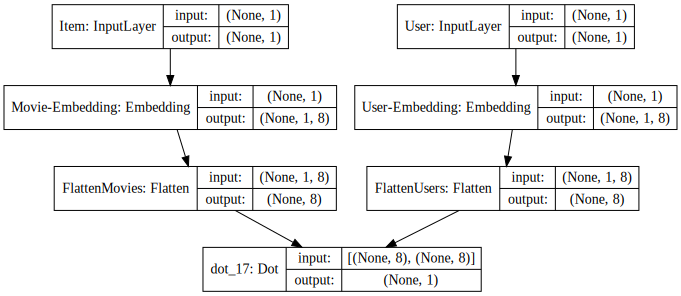

In [126]:
SVG(model_to_dot(model,  show_shapes=True, show_layer_names=True, rankdir='HB').create(prog='dot', format='svg'))

In [127]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Item (InputLayer)               (None, 1)            0                                            
__________________________________________________________________________________________________
User (InputLayer)               (None, 1)            0                                            
__________________________________________________________________________________________________
Movie-Embedding (Embedding)     (None, 1, 8)         77800       Item[0][0]                       
__________________________________________________________________________________________________
User-Embedding (Embedding)      (None, 1, 8)         4888        User[0][0]                       
__________________________________________________________________________________________________
FlattenMov

In [128]:
history = model.fit([train.userId, train.movieId], train.rating, epochs=100, verbose=0)


Text(0, 0.5, 'Train Error')

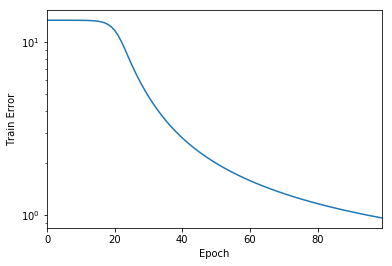

In [129]:
import matplotlib.pyplot as plt
pd.Series(history.history['loss']).plot(logy=True)
plt.xlabel("Epoch")
plt.ylabel("Train Error")

In [130]:
y_hat = np.round(model.predict([test.userId, test.movieId]),0)
y_true = test.rating

In [131]:
from sklearn.metrics import mean_squared_error
err = mean_squared_error(y_true, y_hat)
print(np.sqrt(err))

1.2547262889943505
